<a href="https://colab.research.google.com/github/harjeet88/stock-prediction/blob/main/grok/stock_trader_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=6705f9023a9b5c799cc6c66be8aa5abce6389bb9864d6be354ff53d8bc4bb351
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.trend import MACD, SMAIndicator
from ta.momentum import RSIIndicator
from scipy.signal import find_peaks
import datetime


In [42]:
# Define the stock ticker and date range
ticker = "Kfintech.NS"  # Change to any stock ticker
start_date = "2023-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

# Fetch stock data
stock = yf.Ticker(ticker)
df = stock.history(start=start_date, end=end_date)

In [43]:
# Fundamental Analysis
info = stock.info
fundamentals = {
    "Company": info.get("longName", "N/A"),
    "Sector": info.get("sector", "N/A"),
    "P/E Ratio": info.get("trailingPE", "N/A"),
    "EPS": info.get("trailingEps", "N/A"),
    "Dividend Yield": info.get("dividendYield", "N/A"),
    "Market Cap": info.get("marketCap", "N/A"),
    "52 Week High": info.get("fiftyTwoWeekHigh", "N/A"),
    "52 Week Low": info.get("fiftyTwoWeekLow", "N/A")
}

print("\nFundamental Analysis for", ticker)
for key, value in fundamentals.items():
    print(f"{key}: {value}")


Fundamental Analysis for Kfintech.NS
Company: KFin Technologies Limited
Sector: Technology
P/E Ratio: 68.748055
EPS: 19.25
Dividend Yield: 0.43
Market Cap: 227857727488
52 Week High: 1641.35
52 Week Low: 690.7


In [44]:
# Technical Indicators
# MACD
macd = MACD(df["Close"], window_slow=26, window_fast=12, window_sign=9)
df["MACD"] = macd.macd()
df["MACD_Signal"] = macd.macd_signal()
df["MACD_Hist"] = macd.macd_diff()

In [45]:
# RSI
rsi = RSIIndicator(df["Close"], window=14)
df["RSI"] = rsi.rsi()

In [46]:
# Supertrend
def supertrend(df, period=10, multiplier=3):
    hl2 = (df["High"] + df["Low"]) / 2
    atr = (df["High"] - df["Low"]).rolling(window=period).mean()
    upperband = hl2 + (multiplier * atr)
    lowerband = hl2 - (multiplier * atr)
    supertrend = pd.Series(index=df.index, dtype=float)
    trend = pd.Series(index=df.index, dtype=bool)

    for i in range(1, len(df)):
        if df["Close"].iloc[i-1] > supertrend.iloc[i-1]:
            supertrend.iloc[i] = lowerband.iloc[i]
            trend.iloc[i] = True  # Uptrend
        else:
            supertrend.iloc[i] = upperband.iloc[i]
            trend.iloc[i] = False  # Downtrend
        if i == 1:
            supertrend.iloc[i] = lowerband.iloc[i]
            trend.iloc[i] = True

    return supertrend, trend

df["Supertrend"], df["Trend"] = supertrend(df)

In [53]:
# Enhanced Elliott Wave Detection
def calculate_fibonacci_levels(wave_start, wave_end):
    diff = wave_end - wave_start
    fib_382 = wave_end - 0.382 * diff
    fib_50 = wave_end - 0.5 * diff
    fib_618 = wave_end - 0.618 * diff
    return fib_382, fib_50, fib_618

In [47]:
# Elliott Wave (Simplified Peak/Trough Detection)
def detect_elliott_wave(df, prominence=0.05):
    prices = df["Close"].values
    peaks, _ = find_peaks(prices, prominence=prominence * prices.mean())
    troughs, _ = find_peaks(-prices, prominence=prominence * prices.mean())
    return peaks, troughs

peaks, troughs = detect_elliott_wave(df)

In [48]:
# Generate Trade Signals
def generate_trade_signals(df):
    buy_signals = []
    sell_signals = []
    df["Signal"] = 0  # 0: No signal, 1: Buy, -1: Sell

    for i in range(1, len(df)):
        # Buy: MACD crossover, RSI < 40, price above Supertrend, near trough
        if (df["MACD"].iloc[i] > df["MACD_Signal"].iloc[i] and
            df["MACD"].iloc[i-1] <= df["MACD_Signal"].iloc[i-1] and
            df["RSI"].iloc[i] < 40 and
            df["Trend"].iloc[i] and
            any(abs(i - t) <= 5 for t in troughs)):
            df["Signal"].iloc[i] = 1
            buy_signals.append(i)
        # Sell: MACD crossunder, RSI > 60, price below Supertrend, near peak
        elif (df["MACD"].iloc[i] < df["MACD_Signal"].iloc[i] and
              df["MACD"].iloc[i-1] >= df["MACD_Signal"].iloc[i-1] and
              df["RSI"].iloc[i] > 60 and
              not df["Trend"].iloc[i] and
              any(abs(i - p) <= 5 for p in peaks)):
            df["Signal"].iloc[i] = -1
            sell_signals.append(i)

    return buy_signals, sell_signals

buy_signals, sell_signals = generate_trade_signals(df)

/tmp/ipython-input-48-4290312396.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["Signal"].iloc[i] = -1
/tmp/ipython-input-48-4290312396.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

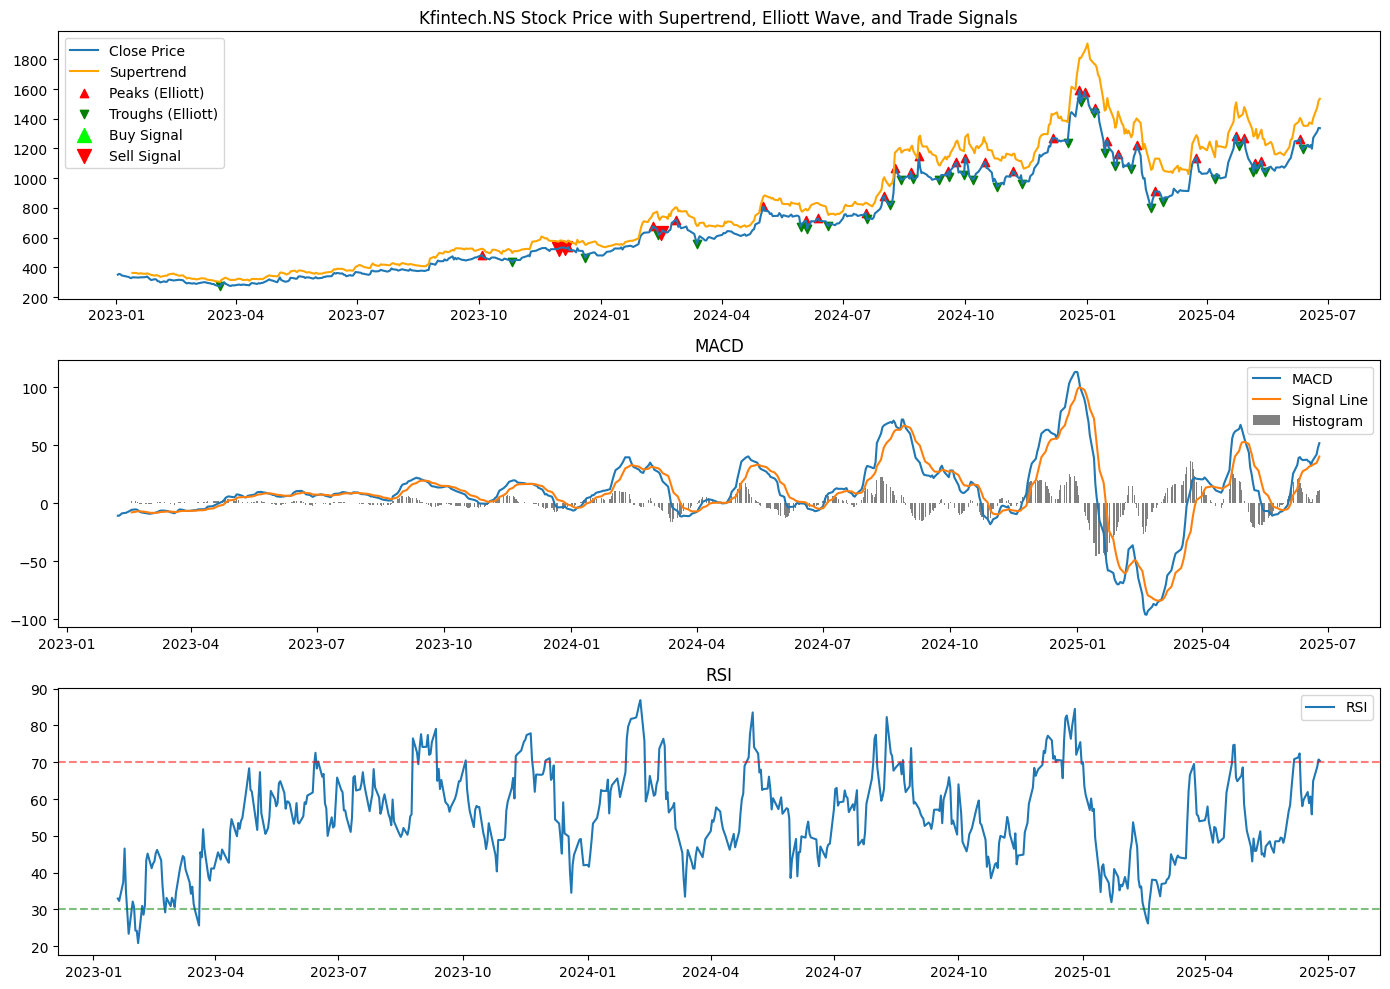

In [49]:
# Plotting
plt.figure(figsize=(14, 10))

# Price and Supertrend with Signals
plt.subplot(3, 1, 1)
plt.plot(df.index, df["Close"], label="Close Price")
plt.plot(df.index, df["Supertrend"], label="Supertrend", color="orange")
plt.scatter(df.index[peaks], df["Close"].iloc[peaks], color="red", marker="^", label="Peaks (Elliott)")
plt.scatter(df.index[troughs], df["Close"].iloc[troughs], color="green", marker="v", label="Troughs (Elliott)")
plt.scatter(df.index[buy_signals], df["Close"].iloc[buy_signals], color="lime", marker="^", s=100, label="Buy Signal")
plt.scatter(df.index[sell_signals], df["Close"].iloc[sell_signals], color="red", marker="v", s=100, label="Sell Signal")
plt.title(f"{ticker} Stock Price with Supertrend, Elliott Wave, and Trade Signals")
plt.legend()

# MACD
plt.subplot(3, 1, 2)
plt.plot(df.index, df["MACD"], label="MACD")
plt.plot(df.index, df["MACD_Signal"], label="Signal Line")
plt.bar(df.index, df["MACD_Hist"], label="Histogram", color="gray")
plt.title("MACD")
plt.legend()

# RSI
plt.subplot(3, 1, 3)
plt.plot(df.index, df["RSI"], label="RSI")
plt.axhline(70, color="red", linestyle="--", alpha=0.5)
plt.axhline(30, color="green", linestyle="--", alpha=0.5)
plt.title("RSI")
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
# Print latest indicator values and trade signals
print("\nLatest Technical Indicator Values:")
print(f"MACD: {df['MACD'].iloc[-1]:.2f}, Signal: {df['MACD_Signal'].iloc[-1]:.2f}, Histogram: {df['MACD_Hist'].iloc[-1]:.2f}")
print(f"RSI: {df['RSI'].iloc[-1]:.2f}")
print(f"Supertrend: {df['Supertrend'].iloc[-1]:.2f}, Trend: {'Up' if df['Trend'].iloc[-1] else 'Down'}")


Latest Technical Indicator Values:
MACD: 51.72, Signal: 40.22, Histogram: 11.50
RSI: 70.35
Supertrend: 1534.23, Trend: Down


In [51]:
# Print latest indicator values and trade signals
print("\nLatest Technical Indicator Values:")
print(f"MACD: {df['MACD'].iloc[-1]:.2f}, Signal: {df['MACD_Signal'].iloc[-1]:.2f}, Histogram: {df['MACD_Hist'].iloc[-1]:.2f}")
print(f"RSI: {df['RSI'].iloc[-1]:.2f}")
print(f"Supertrend: {df['Supertrend'].iloc[-1]:.2f}, Trend: {'Up' if df['Trend'].iloc[-1] else 'Down'}")



Latest Technical Indicator Values:
MACD: 51.72, Signal: 40.22, Histogram: 11.50
RSI: 70.35
Supertrend: 1534.23, Trend: Down


In [52]:
# Latest trade signal and suggested entry/exit
latest_signal = df["Signal"].iloc[-1]
latest_price = df["Close"].iloc[-1]
if latest_signal == 1:
    print(f"\nLatest Signal: BUY at {latest_price:.2f}")
    print(f"Suggested Stop-Loss: {latest_price * 0.97:.2f} (3% below entry)")
    print(f"Suggested Take-Profit: {latest_price * 1.05:.2f} (5% above entry)")
elif latest_signal == -1:
    print(f"\nLatest Signal: SELL at {latest_price:.2f}")
    print(f"Suggested Stop-Loss: {latest_price * 1.03:.2f} (3% above exit)")
    print(f"Suggested Take-Profit: {latest_price * 0.95:.2f} (5% below exit)")
else:
    print("\nNo clear trade signal at the moment. Monitor for next signal.")
    print(f"Current Price: {latest_price:.2f}")
    if df["Trend"].iloc[-1]:
        print(f"Trend is UP. Consider buying on pullback to {df['Supertrend'].iloc[-1]:.2f} with RSI < 40 and MACD bullish crossover.")
    else:
        print(f"Trend is DOWN. Consider selling on rally to {df['Supertrend'].iloc[-1]:.2f} with RSI > 60 and MACD bearish crossover.")


No clear trade signal at the moment. Monitor for next signal.
Current Price: 1336.70
Trend is DOWN. Consider selling on rally to 1534.23 with RSI > 60 and MACD bearish crossover.
